<a href="https://colab.research.google.com/github/Rekt77/kisa_insuretech/blob/master/openCV_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EAST TEXT detector

- blob의 첫 번째 매개변수 이미지자체
- 두번째 매개변수는 픽셀 값의 배율 디폴트 1로 사용
- 네트워크의 기본 입력값은 320x320이므로 320,320이 3번째 인자로 들어감
- 모델을 훈련시키기 위하여 사용하였던 모든 이미지의 BGR의 평균값을 내어 이미지에서 빼줌
  - 이 경우에는 123.68, 116.78, 103.94
- swapRB는 BGR형태를 RGB로 바꿀 것인지에 관한 것
- crop은 이미지를 자르고 자른 이미지를 중심 값으로 할 것이냐이므로 False

[원본 깃허브](https://github.com/argman/EAST)


[INFO] loading EAST text detector...
[INFO] text detection took 0.672413 seconds


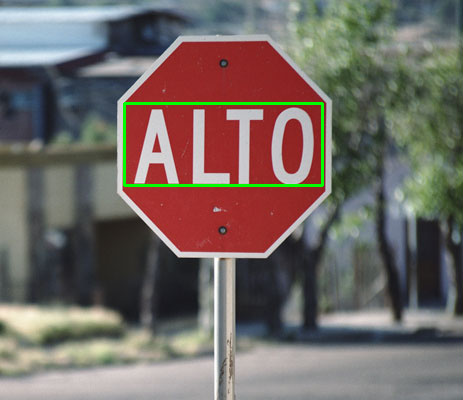

True

In [0]:
from imutils.object_detection import non_max_suppression
import cv2
from google.colab.patches import cv2_imshow
import glob
import numpy as np
import argparse
import time

pb_path = "/content/drive/My Drive/insuretech/frozen_east_text_detection.pb"
img_path = "/content/drive/My Drive/insuretech/test_img/sign.jpg"

image = cv2.imread(img_path)
orig = image.copy()
(H, W) = image.shape[:2]

(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

#blob의 입력값을 맞추기 위하여 320x320으로 리사이징
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# 불러온 모델에 정의되어 있는 레이어
# concat은 이미지에서 텍스트를 감지하고 상자를 생성
# sigmoid 레이어는 감지된 상자의 신뢰도를 연산
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# 이미 학습된 모델 불러오기
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(pb_path)

#blob 생성
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()

#네트워크에 blob을 통과시킴
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# 그려진 박스를 찾는 루틴
for y in range(0, numRows):

	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	for x in range(0, numCols):
		if scoresData[x] < 0.5:
			continue

		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
  
    #사각형의 좌표를 찾아 rects에 더함
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# 찾은 텍스트데이터 박스의 신뢰도를 구함
boxes = non_max_suppression(np.array(rects), probs=confidences)

# box 그리기
for (startX, startY, endX, endY) in boxes:

	# startX,startY,endX,endY는 줄여진 이미지에서 박스좌표
  # 줄여진 비율 만큼을 다시 곱해서 박스 크기를 키움
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(orig)
cv2.imwrite(img_path.split(".")[0]+"_result."+img_path.split(".")[1],orig)